LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting (download the PDF).

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

We add a new Dropout layer between the input (or visible layer) and the first hidden layer. The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

In [10]:
import keras
import tensorflow as tf
%matplotlib inline
import os, sys
print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

python:2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609], keras:2.0.2, tensorflow: 1.0.0


Epoch 1/1
0s - loss: 0.0057
Epoch 1/1
0s - loss: 0.0141
Epoch 1/1
0s - loss: 0.0099
Epoch 1/1
0s - loss: 0.0072
Epoch 1/1
0s - loss: 0.0060
Epoch 1/1
0s - loss: 0.0057
Epoch 1/1
0s - loss: 0.0056
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0053
Epoch 1/1
0s - loss:

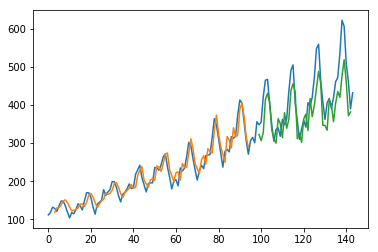

In [19]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size=1
model = Sequential()

#model.add(LSTM(4, input_dim=look_back))

#changes memory end model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

#changes to implement stacked memory starts
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
#changes to implement stacked memory ends

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


#model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
# make predictions
#trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

#Changes to take leverage of the memory in LSTM --starts
for i in range(100):
	model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
#Changes to take leverage of the memory in LSTM -- ends

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1. For example:

In [ ]:
#reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

LSTM with Memory Between Batches

The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states(). 

In [ ]:
for i in range(100):
	model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. 

In [ ]:
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))

This same batch size must then be used later when evaluating the model and making predictions

In [ ]:
model.predict(trainX, batch_size=batch_size)